In [0]:
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [0]:
# yes, you can read dataframes from URLs!
from google.colab import files
uploaded = files.upload()


Saving sbux.csv to sbux.csv


In [0]:
!ls

sample_data  sbux.csv


In [0]:
#df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples')
df = pd.read_csv('sbux.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [0]:
df.tail()

,date,open,high,low,close,volume,Name,PrevClose,Return
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX,56.81,-0.014258
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX,56.00,-0.004107
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX,55.77,-0.019365
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX,54.69,0.016822
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX,55.61,-0.020680


In [0]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [0]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [0]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [0]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
    metrics=['accuracy']
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 1s 27ms/step - loss: 0.0447 - accuracy: 0.0000e+00 - val_loss: 0.0407 - val_accuracy: 0.0000e+00
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0076 - accuracy: 0.0000e+00 - val_loss: 0.0455 - val_accuracy: 0.0000e+00
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0087 - accuracy: 0.0000e+00 - val_loss: 0.0227 - val_accuracy: 0.0000e+00
Epoch 4/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0217 - val_accuracy: 0.0000e+00
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0185 - val_accuracy: 0.0000e+00
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 0.0157 - val_accuracy: 0.0000e+00
Epoch 7/80
20/20 [==============================] - 0s 8ms/step - loss: 0.0072 - accuracy: 0.0000e+00 - val_los

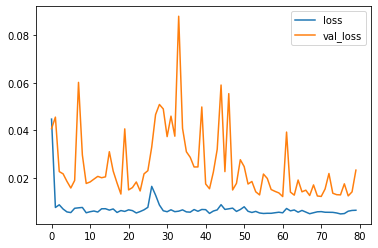

In [0]:
# plot accuracy per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


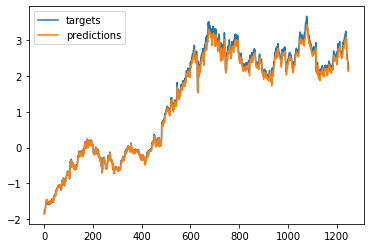

In [0]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

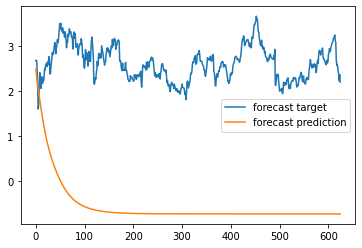

In [0]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [0]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1)  # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [0]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [0]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose'] 

In [0]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


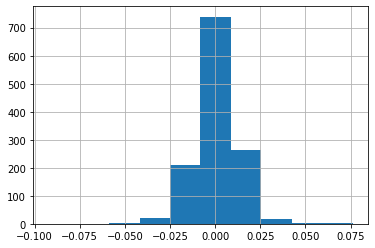

In [0]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [0]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [0]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [0]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1)
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 0s 23ms/step - loss: 1.0003 - val_loss: 1.1500
Epoch 2/80
20/20 [==============================] - 0s 7ms/step - loss: 1.0022 - val_loss: 1.1805
Epoch 3/80
20/20 [==============================] - 0s 7ms/step - loss: 1.0089 - val_loss: 1.1866
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9774 - val_loss: 1.1905
Epoch 5/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9995 - val_loss: 1.1975
Epoch 6/80
20/20 [==============================] - 0s 7ms/step - loss: 1.0101 - val_loss: 1.1595
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9946 - val_loss: 1.1705
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9830 - val_loss: 1.2265
Epoch 9/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9853 - val_loss: 1.1906
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9567 - val_loss: 1.2005
Epoch 11/80
20/20 

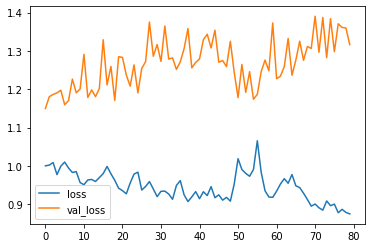

In [0]:
# plot accuracy per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


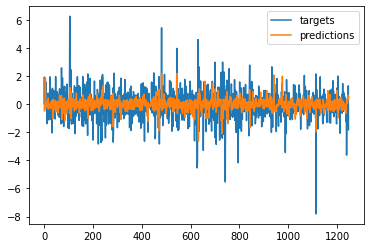

In [0]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

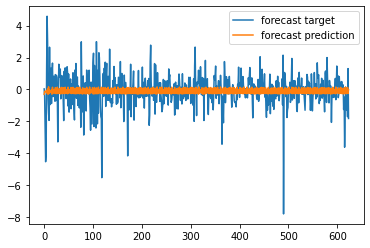

In [0]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [0]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [0]:
# Now make the actual data which will go into the nerual network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 same thing)

In [0]:
# normalize the inputs
Ntrain = len(input_data) * 2// 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [0]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [0]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N -Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N-Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [0]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)


In [0]:
# train the RNN
r = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 1s 27ms/step - loss: 0.6978 - accuracy: 0.4732 - val_loss: 0.6949 - val_accuracy: 0.4854
Epoch 2/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6930 - accuracy: 0.5161 - val_loss: 0.6961 - val_accuracy: 0.4829
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5232 - val_loss: 0.6926 - val_accuracy: 0.5024
Epoch 4/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.5173 - val_loss: 0.6926 - val_accuracy: 0.5024
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5256 - val_loss: 0.6978 - val_accuracy: 0.4878
Epoch 6/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5149 - val_loss: 0.6958 - val_accuracy: 0.4878
Epoch 7/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5256 - val_loss: 0.6923 - val_accuracy: 0.5049
Epoch 8/300


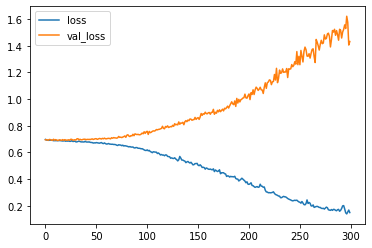

In [0]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

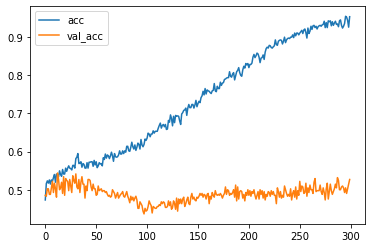

In [0]:
# plot the loss
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()